## Log in to Huggingface

In [1]:
 !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `cmsc691` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `cmsc691`


In [2]:
!huggingface-cli whoami

reecejrobertson


## Installations and imports

Install the necessary libraries, then import the installed packages.

In [3]:
!pip install lambeq
!pip install discopy
!pip install rouge-score
!pip install pytket pytket-qiskit
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=12469730736a30483f82286bdce6f63d3dd46feb4557d120772a42b394716805
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import random
import statistics
from pytket import Qubit
from rouge_score import rouge_scorer
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils.operators import QubitPauliOperator
from lambeq import AtomicType, BobcatParser, IQPAnsatz
from nltk.translate.bleu_score import modified_precision
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

## Setup the Large Language Model

Download and install the Llama 2 model. This step may take several minutes to complete.

In [5]:
# From the Llama-2 Chat Tutorial
# https://colab.research.google.com/drive/1X1z9Q6domMKl2CnEM0QGHNwidLfR4dW2?usp=sharing#scrollTo=THqfvzHIjSK9

model_name = "meta-llama/Llama-2-7b-chat-hf"
quantization_config = BitsAndBytesConfig(load_in_4bit=True) # https://discuss.huggingface.co/t/correct-usage-of-bitsandbytesconfig/33809
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Define Validation Functions

First, get the lambeq model for the quantum validation function. Also define variables needed for the quantum model.

In [6]:
lambeqParser = BobcatParser()
N = AtomicType.NOUN
S = AtomicType.SENTENCE
quantumAnsatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
quantumBackend = AerBackend()
parameterValue = 0.25

Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


Then define the helper functions for the lambeq quantum validator.

In [7]:
def generateQuantumCircuit(sentence, draw):
  diagram = lambeqParser.sentence2diagram(sentence)
  circuit = quantumAnsatz(diagram)
  tketCircuit = circuit.to_tk()
  parameters = dict.fromkeys(tketCircuit.free_symbols(), parameterValue)
  tketCircuit.symbol_substitution(parameters)
  compiledCircuit = quantumBackend.get_compiled_circuit(tketCircuit)
  if draw:
    diagram.draw()
    render_circuit_jupyter(tketCircuit)
  return compiledCircuit

def generateZObservable(circuit):
  n = circuit.n_qubits
  observableString = QubitPauliString({Qubit(i): Pauli.Z for i in range(n)})
  observable = QubitPauliOperator({observableString: 1})
  return observable

def similarity(exp1, exp2):
  distance = abs(exp1 - exp2)
  similarity = 1 / (1 + distance)
  return similarity

An example of the DisCoCat string diagram and quantum circuit representation.

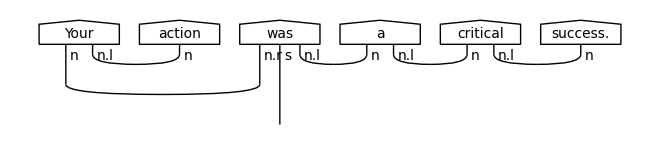

[TK1(0, 0, 0.5) q[0]; TK1(0, 3.75, 3) q[1]; TK1(0.5, 0.5, 0.5) q[2]; TK1(0, 1.5, 0.5) q[3]; TK1(0.25, 2.5, 3.5) q[4]; TK1(1.75, 3.5, 3.5) q[5]; TK1(0, 0, 0.5) q[6]; TK1(0, 3.75, 3) q[7]; TK1(0, 0, 0.5) q[8]; TK1(0, 3.75, 3) q[9]; TK1(0.5, 0.5, 0.5) q[10]; CX q[0], q[1]; CX q[3], q[4]; CX q[6], q[7]; CX q[8], q[9]; TK1(0.5, 1.25, 3.5) q[0]; TK1(0, 1.5, 1.75) q[1]; TK1(0, 1, 3.75) q[4]; TK1(0.5, 0.25, 3.5) q[6]; TK1(0, 0.5, 1.75) q[7]; TK1(0.5, 0.25, 3.5) q[8]; TK1(0, 0.5, 1.75) q[9]; CX q[0], q[1]; CX q[3], q[4]; CX q[6], q[7]; CX q[8], q[9]; TK1(0, 0.5, 0) q[0]; TK1(0.5, 1.75, 0.5) q[1]; TK1(0, 0.5, 0) q[3]; CX q[4], q[5]; TK1(0.5, 0.5, 0) q[6]; TK1(0.5, 1.75, 0.5) q[7]; TK1(0.5, 0.5, 0) q[8]; TK1(0.5, 1.75, 0.5) q[9]; CX q[1], q[2]; TK1(0, 0, 3.75) q[5]; CX q[7], q[8]; CX q[9], q[10]; Measure q[2] --> c[1]; Measure q[10] --> c[3]; Measure q[8] --> c[5]; TK1(0.5, 0.5, 0) q[1]; CX q[4], q[5]; TK1(0.5, 0.5, 0) q[7]; TK1(0.5, 0.5, 0) q[9]; Measure q[1] --> c[0]; Measure q[9] --> c[2]; Mea

In [8]:
generateQuantumCircuit('Your action was a critical success.', True)

Finally, define functions to compute the BLUE, ROUGE, and LAMBEQ similarity scores between the target and hypothesis.

In [9]:
def BLEU(target, hypothesis, n=1):
  scores = []
  for i in range(len(target.split())):
    scores.append(float(modified_precision(target.split(' ')[i], hypothesis.split(' ')[i], n)))
  return statistics.mean(scores)

def ROUGE(target, hypothesis, n="L"):
  scorer = rouge_scorer.RougeScorer([f'rouge{n}'])
  scores = []
  for i in range(len(target.split())):
    scores.append(scorer.score(target.split()[i], hypothesis.split()[i])[f'rouge{n}'].precision)
  return statistics.mean(scores)

def LAMBEQ(target, hypothesis, draw=False):
  tCirc = generateQuantumCircuit(target, draw)
  hCirc = generateQuantumCircuit(hypothesis, draw)
  tOp = generateZObservable(tCirc)
  hOp = generateZObservable(hCirc)
  tExp = quantumBackend.get_operator_expectation_value(tCirc, tOp)
  hExp = quantumBackend.get_operator_expectation_value(hCirc, hOp)
  return similarity(tExp, hExp)

## Manage Die Rolls

Define a function to roll a dice, and a function to generate the hypothesis for the first sentence the model generates given the dice result.

In [10]:
def rollDice():
    # Simulate a dice roll between 1 and 20
    return random.randint(1, 20)

def getActionHypothesis(diceResult):
  if diceResult == 1:
    return 'Your action was a critical failure.'
  elif diceResult <= 3:
    return 'Your action was a major failure.'
  elif diceResult <= 5:
    return 'Your action was a regular failure.'
  elif diceResult <= 7:
    return 'Your action was a moderate failure.'
  elif diceResult <= 9:
    return 'Your action was a slight failure.'
  elif diceResult <= 11:
    return 'Your action was a slight success.'
  elif diceResult <= 13:
    return 'Your action was a moderate success.'
  elif diceResult <= 16:
    return 'Your action was a regular success.'
  elif diceResult <= 19:
    return 'Your action was a major success.'
  elif diceResult == 20:
    return 'Your action was a critical success.'

## Respond to Actions

Define a function that generates responses to player actions. This function incorporates a dice result.

In [11]:
def generate_game_response(history, action, dice_result):
    # Combine the game history into a cohesive context
    history_context = " ".join(history[-3:])  # Use the last 3 situations for context

    print(f"\n[DICE ROLL: {dice_result}]")

    prompt = f"""You are narrating an interactive fiction game. Given the game history, the dice result, and player's action, describe what happens in a 2-3 sentence response. Focus only on the immediate new situation.

The first sentence of your response should be exactly 6 words and should indicate the success or failure of the players action given the dice result. Below are some example first sentences given various dice results:

Example 1

Dice result: 20

What happens next: You action was a critical success.

Example 2

Dice result: 17

What happens next: Your action was a major success.

Example 3

Dice result: 15

What happens next: Your action was a regular success.

Example 4

Dice result: 13

What happens next: Your action was a moderate success.

Example 5

Dice result: 11

What happens next: Your action was a slight success.

Example 6

Dice result: 9

What happens next: Your action was a slight failure.

Example 7

Dice result: 7

What happens next: Your action was a moderate failure.

Example 8

Dice result: 5

What happens next: Your action was a regular failure

Example 9

Dice result: 3

What happens next: Your action was a major failure.

Example 10

Dice result: 1

What happens next: Your action was a critical failure.

This concludes the examples. Now, given the below history, player action, and dice result, generate the one sentence success description, and then 1-2 more sentences describing the result of the action.

Game history:
{history_context}

Player action: {action}

Dice result: {dice_result}

What happens next:"""

    model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    output = model.generate(**model_inputs, max_length=1024, temperature=0.7)
    new_situation = tokenizer.decode(output[0], skip_special_tokens=True)[len(prompt):].strip()

    # Return only the new situation
    return new_situation

## Run the Game

Prompt the model to set the scene, then begin the game loop. The model will accept a user action, generate a dice result, and then generate a discription of the action result. Validate the first sentence of the action using the BLEU, ROGUE, and LAMBEQ similarity functions. The intent behind this is to ensure that the model understands the relative success of the player's action and tailors the response accordingly.

In [12]:
# Generate initial game setting
setting_prompt = """You are creating an interactive fiction game. Describe the initial setting and situation the player finds themselves in. Keep it to 2-3 sentences."""

model_inputs = tokenizer(setting_prompt, return_tensors="pt").to("cuda:0")
output = model.generate(**model_inputs, max_length=1024, temperature=0.7)
initial_situation = tokenizer.decode(output[0], skip_special_tokens=True).strip()

# Initialize game memory with the initial situation
game_memory = [initial_situation]

print("\nWelcome to the AI Generated Adventure!")
print("\nYour situation:", initial_situation)

# Main game loop
while True:
    print("\nWhat would you like to do? (type 'quit' to end)")
    action = input("> ")

    if action.lower() == 'quit':
        print("\nThanks for playing!")
        break

    # Generate response based on memory and player's action
    dice_result = rollDice()
    response = generate_game_response(game_memory, action, dice_result)
    game_memory.append(response)  # Add the new situation to memory

    # Keep only the last 5 memories
    game_memory = game_memory[-5:]

    print("\n" + response)

    # Validate the first sentence of the response
    target = ' '.join(response.split(' ')[:6])
    hypothesis = getActionHypothesis(dice_result)
    print('Memory Count:\t', len(game_memory))
    print('Target:\t\t', target)
    print('Hypothesis:\t', hypothesis)
    print('BLEU:\t\t', BLEU(target, hypothesis))
    print('ROUGE:\t\t', ROUGE(target, hypothesis))
    print('LAMBEQ:\t\t', LAMBEQ(target, hypothesis))

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(



Welcome to the AI Generated Adventure!

Your situation: You are creating an interactive fiction game. Describe the initial setting and situation the player finds themselves in. Keep it to 2-3 sentences.

The sun sets over a small, coastal town, casting a warm orange glow over the quaint buildings and bustling streets. The player, a young woman named Sarah, stands on the edge of the town square, her backpack slung over her shoulder and a sense of excitement in her heart. She has just arrived in this unfamiliar place, drawn by rumors of a mysterious artifact hidden somewhere in the nearby woods.

What would you like to do? (type 'quit' to end)
> Go to the inn to ask someone about the artifact in the woods.

[DICE ROLL: 14]

You enter the inn and approach the barkeep, who looks up from his mug of ale with a curious expression. "What can I get for ye?" he asks, eyeing ye with a mix of curiosity and suspicion. Ye explain yer quest, and the barkeep nods thoughtfully before leaning in close.